## Importing

In [ ]:
!pip install textattack

  Using cached textattack-0.3.10-py3-none-any.whl (445 kB)
  Using cached bert_score-0.3.13-py3-none-any.whl (61 kB)
  Using cached flair-0.13.1-py3-none-any.whl (388 kB)
  Using cached language_tool_python-2.8-py3-none-any.whl (35 kB)
  Using cached lemminflect-0.2.3-py3-none-any.whl (769 kB)
  Using cached lru_dict-1.3.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30 kB)
  Using cached datasets-2.19.1-py3-none-any.whl (542 kB)
  Using cached terminaltables-3.1.10-py2.py3-none-any.whl (15 kB)
  Using cached word2number-1.1.zip (9.7 kB)
  Preparing metadata (setup.py) ... done
  Using cached num2words-0.5.13-py3-none-any.whl (143 kB)
  Using cached pinyin-0.4.0.tar.gz (3.6 MB)
  Preparing metadata (setup.py) ... done
  Using cached OpenHowNet-2.0-py3-none-any.whl (18 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached 

In [ ]:
import textattack
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
import transformers
from textattack.attack_results.successful_attack_result import SuccessfulAttackResult
from textattack.shared.word_embeddings import WordEmbedding
import numpy as np
import json
from numpy import dot
from numpy.linalg import norm
import pandas as pd
from IPython.core.display import display, HTML
from textattack.loggers import CSVLogger
import torch
from textattack.models.helpers.lstm_for_classification import LSTMForClassification
from textattack.models.wrappers.pytorch_model_wrapper import PyTorchModelWrapper
from textattack.datasets import HuggingFaceDataset
from sklearn.metrics import accuracy_score

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Helper Functions

In [ ]:
def load_model_and_tokenizer(hugging_face_path):
    model = transformers.AutoModelForSequenceClassification.from_pretrained(hugging_face_path)
    tokenizer = transformers.AutoTokenizer.from_pretrained(hugging_face_path)
    model_wrapper = textattack.models.wrappers.HuggingFaceModelWrapper(model, tokenizer)
    return model_wrapper


def get_use_embeddings(use, succesful_attacks):
    original_texts = [res.original_text() for res in succesful_attacks]
    adversarial_texts = [res.perturbed_text() for res in succesful_attacks]
    use_original_embeddings = use.encode(original_texts)
    use_adv_embeddings = use.encode(adversarial_texts)
    return use_original_embeddings, use_adv_embeddings


def get_avg_cosine_sim(original_embeddings, adv_embeddings):
    # Compute avg. cosine similarity between the embeddings computed using the Universal Sentence Encoding
    cos_sim = []
    sim_metric = torch.nn.CosineSimilarity(dim=1)
    cosine_similarities = sim_metric(torch.tensor(original_embeddings),
                                     torch.tensor(adv_embeddings))
    return np.mean(cosine_similarities.numpy())



def get_cosine_sim(original_embeddings, adv_embeddings):
    cos_sim = []
    sim_metric = torch.nn.CosineSimilarity(dim=1)
    cosine_similarities = sim_metric(torch.tensor(original_embeddings),
                                     torch.tensor(adv_embeddings))
    return cosine_similarities.numpy().tolist()


def get_words_embedding_distances(embedding, original_text,
                                  adv_text):
    word_distances = []
    for word, adv_word in zip(original_text, adv_text):
        if word != adv_word:
            # print(word, adv_word)
            try:
              cos_sim = embedding.get_cos_sim(word, adv_word)
            except KeyError:
              continue
            word_distances.append( (word, adv_word, cos_sim) )

    return word_distances


def get_min_words_distance(embedding, succesful_attacks):
    min_distances = []
    for res in succesful_attacks:
        original_text = res.original_result.attacked_text.words
        adversarial_text = res.perturbed_result.attacked_text.words
        if len(original_text) != len(adversarial_text):
            continue
        embedding_distances = get_words_embedding_distances(embedding,
                                                            original_text,
                                                            adversarial_text)
        # Get the words with minimum embedding cosine similarity
        if len(embedding_distances) == 0:
            continue
        min_words_distance_i = min(embedding_distances, key = lambda x: x[2])
        min_distances.append(min_words_distance_i)
    return min_distances

def display_results(attacks_results, output_file):
    pd.options.display.max_colwidth = (
    480  # increase colum width so we can actually read the examples
    )

    logger = CSVLogger(color_method="html")

    for result in attacks_results:
        if isinstance(result, SuccessfulAttackResult):
            logger.log_attack_result(result)

    results = pd.DataFrame.from_records(logger.row_list)

    if not results.empty:
        html_content = results[["original_text", "perturbed_text"]].to_html(escape=False)

        with open(output_file, 'w') as file:
            file.write(html_content)


def transfer_attack(model_wrapper, succesful_attacks):
    original_text = [res.original_text() for res in succesful_attacks]
    adversarial_text = [res.perturbed_text() for res in succesful_attacks]
    original_labels = [res.original_result.ground_truth_output for res in succesful_attacks]
    original_model_predicted_labels = np.argmax(model_wrapper(original_text), axis=1)
    adv_model_pred_labels = np.argmax(model_wrapper(adversarial_text), axis=1)

    original_accuracy = accuracy_score(original_labels,
                                       original_model_predicted_labels)
    adv_accuracy = accuracy_score(original_labels, adv_model_pred_labels)
    return original_accuracy, adv_accuracy


def create_results_dict(original_embeddings, adversarial_embeddings, cosine_sim,
                    perturbed_embedding_distances):
    use_data_dic = {}
    use_data_dic['original_embeddings'] = original_embeddings
    use_data_dic['adversarial_embeddings'] = adversarial_embeddings
    use_data_dic['cosine_sim'] = cosine_sim
    use_data_dic['perturbed_embedding_distances'] = perturbed_embedding_distances
    return use_data_dic

def dictToJSON(data, filename = "data.json"):
  with open(filename, 'w') as f:
    json.dump(data, f)


def perform_attack(adv_alg, model, dataset, file_name, parallel = True):
    attack = adv_alg.build(model)
    attack_args = textattack.AttackArgs(num_examples=-1, parallel = parallel,
                                        disable_stdout = True)
    attacker = Attacker(attack, dataset, attack_args)
    adv_results = attacker.attack_dataset()

    display_results(adv_results, file_name)

    succesful_attacks = list(filter(lambda res: isinstance(res, SuccessfulAttackResult),
                          adv_results))
    results_dict = {}
    if len(succesful_attacks) != 0:
        original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                            succesful_attacks)

        avg_use_cosine_sim = get_avg_cosine_sim(original_embeddings,adv_embeddings)
        print(f"Average cosine similarity {avg_use_cosine_sim}")

        cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)

        min_embedding_distances = get_min_words_distance(word_embedding,
                                                 succesful_attacks)
        perturbed_embedding_distances = [x[2] for x in min_embedding_distances]

        for i,med in enumerate(min_embedding_distances):
            print(f"Adv example: {i}")
            print(f"Original word: {med[0]}")
            print(f"Perturbed word: {med[1]}")
            print(f"Minimum Cosine similarity among words: {med[2]}")
            print()

        results_dict = create_results_dict(original_embeddings.tolist(),
                                      adv_embeddings.tolist(),
                                      cosine_sim,
                                      perturbed_embedding_distances)

        return results_dict, succesful_attacks



class FixedHuggingFaceDataset(HuggingFaceDataset):
    def __init__(self, name_or_dataset, subset=None, split="train", dataset_columns=None, label_map=None,
                 label_names=None, output_scale_factor=None, shuffle=False, seed=69, subset_size=None, offset=0):
        super().__init__(name_or_dataset=name_or_dataset, subset=subset, split=split, dataset_columns=dataset_columns,
                         label_map=label_map, label_names=label_names, output_scale_factor=output_scale_factor,
                         shuffle=shuffle)
        if shuffle:
            self._dataset = self._dataset.shuffle(seed=seed).flatten_indices()
        if subset_size is not None:
            self._dataset = self._dataset.skip(offset).take(subset_size)

In [ ]:
use = UniversalSentenceEncoder()
word_embedding = WordEmbedding.counterfitted_GLOVE_embedding()

textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:12<00:00, 38.0MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpuzbth614.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


In [ ]:
models = {}
datasets = {}

## Attacked models

In [ ]:
bert_imdb = load_model_and_tokenizer("textattack/bert-base-uncased-imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
bert_yelp = load_model_and_tokenizer("textattack/bert-base-uncased-yelp-polarity")

config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
bert_ag = load_model_and_tokenizer("textattack/bert-base-uncased-ag-news")

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Attacked model for transferability

In [ ]:
lstm_imdb = LSTMForClassification.from_pretrained("lstm-imdb")

textattack: Downloading https://textattack.s3.amazonaws.com/models_v2/classification/lstm/imdb.
100%|██████████| 297M/297M [00:08<00:00, 33.9MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpyks3bk88.zip to /root/.cache/textattack/models_v2/classification/lstm/imdb.
textattack: Successfully saved models_v2/classification/lstm/imdb to cache.
textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/glove200.
100%|██████████| 389M/389M [00:12<00:00, 32.3MB/s]
textattack: Unzipping file /root/.cache/textattack/tmp9d7misgr.zip to /root/.cache/textattack/word_embeddings/glove200.
textattack: Successfully saved word_embeddings/glove200 to cache.


In [ ]:
tokenizer = lstm_imdb.tokenizer
lstm_imdb_wrapper = PyTorchModelWrapper(lstm_imdb, tokenizer)

## Datasets

In [ ]:
imdb = FixedHuggingFaceDataset("imdb", split="test", subset_size=10, shuffle=True)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

textattack: Loading datasets dataset imdb, split test.


Flattening the indices:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
yelp_polarity = FixedHuggingFaceDataset("yelp_polarity", split="test", subset_size=10, shuffle=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for yelp_polarity contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/yelp_polarity
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

textattack: Loading datasets dataset yelp_polarity, split test.


Flattening the indices:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [ ]:
ag_news = FixedHuggingFaceDataset("ag_news", split="test", subset_size=10, shuffle=True)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

textattack: Loading datasets dataset ag_news, split test.


Flattening the indices:   0%|          | 0/7600 [00:00<?, ? examples/s]

## BAE: BERT-based Adversarial Examples for Text Classification

In [ ]:
from textattack import Attacker
from textattack.attack_recipes import BAEGarg2019

### IMDB

In [ ]:
results_bae_imdb, succesful_attacks = perform_attack(BAEGarg2019,
                                                     bert_imdb,
                                                     imdb,
                                                     "bae_results_imdb.html")
datasets['imdb'] = results_bae_imdb

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Worklist size: 10
textattack: Worklist candidate size: 0
[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [03:38<00:00, 21.89s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 2.17%  |
| Average num. words per input: | 201.2  |
| Avg num queries:              | 252.8  |
+-------------------------------+--------+


textattack: Logging to CSV at path results.csv


textattack: CSVLogger exiting without calling flush().


Average cosine similarity 0.9941909909248352
Adv example: 0
Original word: hard
Perturbed word: nice
Minimum Cosine similarity among words: 0.019867025315761566

Adv example: 1
Original word: also
Perturbed word: too
Minimum Cosine similarity among words: 0.744145393371582

Adv example: 2
Original word: works
Perturbed word: fails
Minimum Cosine similarity among words: -0.027351168915629387

Adv example: 3
Original word: bad
Perturbed word: good
Minimum Cosine similarity among words: -0.0030777789652347565

Adv example: 4
Original word: aged
Perturbed word: unfolded
Minimum Cosine similarity among words: -0.060495901852846146

Adv example: 5
Original word: acting
Perturbed word: film
Minimum Cosine similarity among words: 0.1420210897922516



In [ ]:
#Transferability
bae_original_acc_lstm, bae_adv_acc_lstm = transfer_attack(lstm_imdb_wrapper,
                                                          succesful_attacks)

In [ ]:
print(f"Original accuracy lstm: {bae_original_acc_lstm}")
print(f"Accuracy after the attack lstm: {bae_adv_acc_lstm}")

Original accuracy lstm: 0.8333333333333334
Accuracy after the attack lstm: 0.8333333333333334


### Yelp polarity

In [ ]:
results_bae_yelp, _ = perform_attack(BAEGarg2019,
                                     bert_yelp,
                                     yelp_polarity,
                                     "bae_results_yelp.html")
datasets['yelp'] = results_bae_yelp

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model 


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 77.78% |
| Average perturbed word %:     | 7.19%  |
| Average num. words per input: | 195.3  |
| Avg num queries:              | 344.33 |
+-------------------------------+--------+


textattack: Logging to CSV at path results.csv


textattack: CSVLogger exiting without calling flush().


Average cosine similarity 0.9758443236351013
Adv example: 0
Original word: show
Perturbed word: mess
Minimum Cosine similarity among words: -0.0890916958451271

Adv example: 1
Original word: new
Perturbed word: frozen
Minimum Cosine similarity among words: 0.03213377296924591

Adv example: 2
Original word: order
Perturbed word: wait
Minimum Cosine similarity among words: 0.011086784303188324

Adv example: 3
Original word: best
Perturbed word: few
Minimum Cosine similarity among words: 0.05707116425037384

Adv example: 4
Original word: eat
Perturbed word: return
Minimum Cosine similarity among words: 0.0004444476217031479

Adv example: 5
Original word: incredibly
Perturbed word: not
Minimum Cosine similarity among words: -0.12291844934225082

Adv example: 6
Original word: minus
Perturbed word: plus
Minimum Cosine similarity among words: -0.10777769982814789



### AG news

In [ ]:
results_bae_ag = perform_attack(BAEGarg2019,
                                     bert_ag,
                                     ag_news,
                                     "bae_results_ag.html")
datasets['ag_news'] = results_bae_ag

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model 


+-------------------------------+-------+
| Attack Results                |       |
+-------------------------------+-------+
| Number of successful attacks: | 0     |
| Number of failed attacks:     | 9     |
| Number of skipped attacks:    | 1     |
| Original accuracy:            | 90.0% |
| Accuracy under attack:        | 90.0% |
| Attack success rate:          | 0.0%  |
| Average perturbed word %:     | nan%  |
| Average num. words per input: | 41.6  |
| Avg num queries:              | 143.0 |
+-------------------------------+-------+


/usr/local/lib/python3.10/dist-packages/textattack/metrics/attack_metrics/words_perturbed.py:83: RuntimeWarning: Mean of empty slice.
  average_perc_words_perturbed = self.perturbed_word_percentages.mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
textattack: Logging to CSV at path results.csv


In [ ]:
models['bae'] = datasets.copy()
datasets.clear()

## DeepWordBug

In [ ]:
from textattack.attack_recipes import DeepWordBugGao2018

### IMDB

In [ ]:
results_dwb_imdb, succesful_attacks = perform_attack(DeepWordBugGao2018,
                                                     bert_imdb,
                                                     imdb,
                                                     "dwb_results_imdb.html")
datasets['imdb'] = results_dwb_imdb

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Worklist size: 10
textattack: Worklist candidate size: 0
[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 9.27%  |
| Average num. words per input: | 201.2  |
| Avg num queries:              | 204.4  |
+-------------------------------+--------+


textattack: Logging to CSV at path results.csv


textattack: CSVLogger exiting without calling flush().


Average cosine similarity 0.9208834171295166
Adv example: 0
Original word: crap
Perturbed word: cap
Minimum Cosine similarity among words: 0.03346813842654228

Adv example: 1
Original word: need
Perturbed word: ned
Minimum Cosine similarity among words: -0.030911853536963463

Adv example: 2
Original word: story
Perturbed word: tory
Minimum Cosine similarity among words: -0.004190064966678619

Adv example: 3
Original word: bad
Perturbed word: ba
Minimum Cosine similarity among words: -0.08896875381469727

Adv example: 4
Original word: wife
Perturbed word: wie
Minimum Cosine similarity among words: 0.026262134313583374



In [ ]:
#Transferability
dwb_original_acc_lstm, dwb_adv_acc_lstm = transfer_attack(lstm_imdb_wrapper,
                                                          succesful_attacks)

In [ ]:
print(f"Original accuracy lstm: {dwb_original_acc_lstm}")
print(f"Accuracy after the attack lstm: {dwb_adv_acc_lstm}")

Original accuracy lstm: 0.8888888888888888
Accuracy after the attack lstm: 0.5555555555555556


### Yelp polarity

In [ ]:
results_dwb_yelp, _ = perform_attack(DeepWordBugGao2018,
                                     bert_yelp,
                                     yelp_polarity,
                                     "dwb_results_yelp.html")
datasets['yelp'] = results_dwb_yelp

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Worklist size: 10
textattack: Worklist candidate size: 0
[Succeeded / Failed / Skipped / Total] 6 / 3 / 1 / 10: 100%|██████████| 10/10 [01:26<00:00,  8.64s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 66.67% |
| Average perturbed word %:     | 7.45%  |
| Average num. words per input: | 195.3  |
| Avg num queries:              | 232.67 |
+-------------------------------+--------+


textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().



Average cosine similarity 0.9396641254425049
Adv example: 0
Original word: tip
Perturbed word: ip
Minimum Cosine similarity among words: -0.0039334725588560104

Adv example: 1
Original word: type
Perturbed word: tyre
Minimum Cosine similarity among words: 0.03577409312129021



### AG news

In [ ]:
results_dwb_ag, _ = perform_attack(DeepWordBugGao2018,
                                     bert_ag,
                                     ag_news,
                                     "dwb_results_ag.html")
datasets['ag_news'] = results_dwb_ag

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Worklist size: 10
textattack: Worklist candidate size: 0
[Succeeded / Failed / Skipped / Total] 6 / 3 / 1 / 10: 100%|██████████| 10/10 [00:40<00:00,  4.00s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 66.67% |
| Average perturbed word %:     | 37.53% |
| Average num. words per input: | 41.6   |
| Avg num queries:              | 120.89 |
+-------------------------------+--------+


textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().



Average cosine similarity 0.6435751914978027
Adv example: 0
Original word: world
Perturbed word: word
Minimum Cosine similarity among words: -0.07606035470962524

Adv example: 1
Original word: says
Perturbed word: sas
Minimum Cosine similarity among words: -0.12263944000005722



In [ ]:
models['dwb'] = datasets.copy()
datasets.clear()

## Simulated Annealing

In [ ]:
from textattack.search_methods import SearchMethod
from textattack.goal_function_results import GoalFunctionResultStatus
# from textattack.constraints.pre_transformation import RepeatModification
from textattack.shared.validators import transformation_consists_of_word_swaps
import random
import numpy as np

In [ ]:
class SimulatedAnnealing(SearchMethod):

    def __init__(self, max_temp=100.0, max_iter=10, K=10, radius=3, delta=0.01):
        self.max_temp = max_temp
        self.max_iter = max_iter
        self.K = K
        self.radius = radius
        self.delta = delta

    def _get_score(self, original_text, adversarial_text):
        result, search_over = self.get_goal_results([adversarial_text])
        score = result[0].score
        cost = len(original_text.all_words_diff(adversarial_text))
        y = score - (self.delta * cost)
        return y, search_over, result[0]


    def _get_transformations(self, indices, current_text, initial_result):
        transformations = []
        scores = []
        curr_result = initial_result
        for i in indices:
            t_i = self.get_transformations(
                    current_text,
                    original_text=initial_result.attacked_text,
                    indices_to_modify=[i])
            if len(t_i) == 0:
                transformations.append(current_text.words[i])
                scores.append(curr_result.score)
                continue

            res_i, _ = self.get_goal_results(t_i)
            scores_i = np.array([r.score for r in res_i])
            max_score_index = np.argmax(scores_i)
            curr_result = res_i[max_score_index]
            scores.append(scores_i[max_score_index])
            assert len(t_i[max_score_index].words) == len(current_text.words)
            transformations.append(t_i[max_score_index].words[i])
        return np.array(transformations), np.array(scores)

    def perform_search(self, initial_result):
        best_result = initial_result
        current_text = initial_result.attacked_text
        max_temp = self.max_temp
        t = 0

        _, indices = self.get_indices_to_order(current_text)
        transformations, scores = self._get_transformations(indices, current_text, initial_result)
        transformations = list(transformations[(-scores).argsort()])
        indices = np.array(indices)[(-scores).argsort()]
        n = len(transformations)
        if n == 0:
            return best_result

        while not best_result.goal_status == GoalFunctionResultStatus.SUCCEEDED:
            if max_temp == 0.0 or t == self.max_iter:
                return best_result

            #Internal simulations
            for k in range(self.K):
                index = t + random.randint(0, t*self.radius)
                if index >= n:
                    continue
                original_index = indices[index]
                word_adv = transformations[index]
                next_text = current_text.replace_word_at_index(original_index, word_adv)

                curr_score = best_result.score
                next_score, search_over, result = self._get_score(initial_result.attacked_text, next_text)
                if search_over:
                    return result
                delta = next_score - curr_score
                if (delta > 0) or (random.random() < np.exp(delta / max_temp)):
                    current_text = next_text
                    best_result = result
            t += 1
            #Annealing
            max_temp = max_temp / (t + 1)

        return best_result

    def check_transformation_compatibility(self, transformation):
        """The SA algorithm is specifically designed for word
        substitutions."""
        return transformation_consists_of_word_swaps(transformation)


    @property
    def is_black_box(self):
        return True

    def extra_repr_keys(self):
        return ["max_temp", "max_iter", "K", "radius", "delta"]

In [ ]:
from textattack.attack_recipes.attack_recipe import AttackRecipe
from textattack.transformations import WordSwapMaskedLM
from textattack.goal_functions import UntargetedClassification
from textattack.constraints.grammaticality import PartOfSpeech
from textattack import Attack
# from textattack.constraints.pre_transformation import StopwordModification

In [ ]:
class BESAYang2020(AttackRecipe):

    @staticmethod
    def build(model_wrapper):
        transformation = WordSwapMaskedLM(
            method="bae", max_candidates=50
        )
        # constraints = [StopwordModification()]
        constraints = []
        constraints.append(PartOfSpeech())
        use_constraint = UniversalSentenceEncoder(
            threshold=0.5,
            metric="cosine",
            window_size = 15
        )
        constraints.append(use_constraint)

        goal_function = UntargetedClassification(model_wrapper)
        search_method = SimulatedAnnealing()

        return BESAYang2020(goal_function, constraints, transformation, search_method)




### IMDB

In [ ]:
results_besa_imdb, succesful_attacks = perform_attack(BESAYang2020,
                                                     bert_imdb,
                                                     imdb,
                                                     "besa_results_imdb.html",
                                                      parallel=False)
datasets['imdb'] = results_besa_imdb

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model 

Attack(
  (search_method): SimulatedAnnealing(
    (max_temp):  100.0
    (max_iter):  10
    (K):  10
    (radius):  3
    (delta):  0.01
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.5
        (window_size):  15
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [24:24<00:00, 146.43s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 2.64%  |
| Average num. words per input: | 201.2  |
| Avg num queries:              | 3230.4 |
+-------------------------------+--------+


textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().



Average cosine similarity 0.9809593558311462
Adv example: 0
Original word: soggy
Perturbed word: great
Minimum Cosine similarity among words: 0.08347418159246445

Adv example: 1
Original word: enjoyed
Perturbed word: hate
Minimum Cosine similarity among words: 0.03624125197529793

Adv example: 2
Original word: movie
Perturbed word: world
Minimum Cosine similarity among words: 0.10388033092021942

Adv example: 3
Original word: impressed
Perturbed word: disappointed
Minimum Cosine similarity among words: 0.2799302637577057

Adv example: 4
Original word: bad
Perturbed word: wonderful
Minimum Cosine similarity among words: 0.011220861226320267

Adv example: 5
Original word: surprise
Perturbed word: kill
Minimum Cosine similarity among words: 0.03856436163187027

Adv example: 6
Original word: recommended
Perturbed word: painful
Minimum Cosine similarity among words: -0.051707517355680466

Adv example: 7
Original word: bad
Perturbed word: awesome
Minimum Cosine similarity among words: 0.019

In [ ]:
#Transferability
besa_original_acc_lstm, besa_adv_acc_lstm = transfer_attack(lstm_imdb_wrapper,
                                                          succesful_attacks)

In [ ]:
print(f"Original accuracy lstm: {besa_original_acc_lstm}")
print(f"Accuracy after the attack lstm: {besa_adv_acc_lstm}")

Original accuracy lstm: 0.8888888888888888
Accuracy after the attack lstm: 0.5555555555555556


### Yelp polarity

In [ ]:
results_besa_yelp, _ = perform_attack(BESAYang2020,
                                      bert_yelp,
                                      yelp_polarity,
                                      "besa_results_yelp.html",
                                      parallel=False)
datasets['yelp'] = results_besa_yelp

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model 

Attack(
  (search_method): SimulatedAnnealing(
    (max_temp):  100.0
    (max_iter):  10
    (K):  10
    (radius):  3
    (delta):  0.01
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.5
        (window_size):  15
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 9 / 0 / 1 / 10: 100%|██████████| 10/10 [19:10<00:00, 115.08s/it]


+-------------------------------+---------+
| Attack Results                |         |
+-------------------------------+---------+
| Number of successful attacks: | 9       |
| Number of failed attacks:     | 0       |
| Number of skipped attacks:    | 1       |
| Original accuracy:            | 90.0%   |
| Accuracy under attack:        | 0.0%    |
| Attack success rate:          | 100.0%  |
| Average perturbed word %:     | 4.6%    |
| Average num. words per input: | 195.3   |
| Avg num queries:              | 2848.89 |
+-------------------------------+---------+


textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().



Average cosine similarity 0.9682164788246155
Adv example: 0
Original word: worth
Perturbed word: pass
Minimum Cosine similarity among words: 0.04961663484573364

Adv example: 1
Original word: beautiful
Perturbed word: boring
Minimum Cosine similarity among words: 0.04297740012407303

Adv example: 2
Original word: go
Perturbed word: extremes
Minimum Cosine similarity among words: 0.0578295923769474

Adv example: 3
Original word: plastic
Perturbed word: perfect
Minimum Cosine similarity among words: 0.03763482719659805

Adv example: 4
Original word: best
Perturbed word: worst
Minimum Cosine similarity among words: 0.2249249964952469

Adv example: 5
Original word: southwest
Perturbed word: upscale
Minimum Cosine similarity among words: 0.03139092028141022

Adv example: 6
Original word: incredibly
Perturbed word: not
Minimum Cosine similarity among words: -0.12291844934225082

Adv example: 7
Original word: crab
Perturbed word: station
Minimum Cosine similarity among words: 0.0479109473526

### AG news

In [ ]:
results_besa_ag, _ = perform_attack(BESAYang2020,
                                    bert_ag,
                                    ag_news,
                                    "besa_results_ag.html",
                                    parallel = False)
datasets['ag_news'] = results_besa_ag

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model 

Attack(
  (search_method): SimulatedAnnealing(
    (max_temp):  100.0
    (max_iter):  10
    (K):  10
    (radius):  3
    (delta):  0.01
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.5
        (window_size):  15
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 4 / 1 / 10: 100%|██████████| 10/10 [05:18<00:00, 31.87s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 5      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 55.56% |
| Average perturbed word %:     | 19.29% |
| Average num. words per input: | 41.6   |
| Avg num queries:              | 921.11 |
+-------------------------------+--------+


textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().



Average cosine similarity 0.7381806373596191
Adv example: 0
Original word: trial
Perturbed word: bowl
Minimum Cosine similarity among words: -0.03125035762786865

Adv example: 1
Original word: found
Perturbed word: could
Minimum Cosine similarity among words: 0.2655140161514282

Adv example: 2
Original word: stage
Perturbed word: web
Minimum Cosine similarity among words: 0.03726060688495636

Adv example: 3
Original word: homes
Perturbed word: americans
Minimum Cosine similarity among words: 0.0341065376996994

Adv example: 4
Original word: say
Perturbed word: complex
Minimum Cosine similarity among words: -0.02813364937901497



In [ ]:
models['SA'] = datasets.copy()
datasets.clear()

## Charts / Plots

In [ ]:
dictToJSON(models)

In [ ]:
box_plots_data = []

for model in models.keys():
    cosine_similarities = []
    datasets_i = models[model]
    for dataset in datasets_i.keys():
        dataset_dict = datasets_i[dataset]
        if dataset_dict is not None:
            cosine_similarities +=  dataset_dict['cosine_sim']
    box_plots_data.append(cosine_similarities)

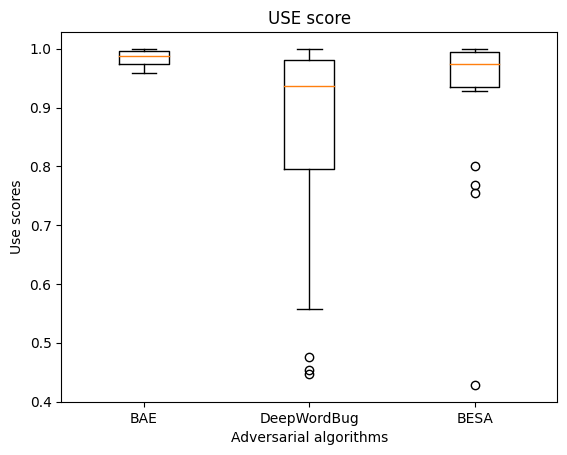

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and an axis
fig, ax = plt.subplots()

# Create the box plots
ax.boxplot(box_plots_data)

# Set the labels for the x-axis
ax.set_xticklabels(['BAE', 'DeepWordBug', 'BESA'])

# Add title and labels
ax.set_title('USE score')
ax.set_xlabel('Adversarial algorithms')
ax.set_ylabel('Use scores')

# Show the plot
plt.show()

## New attack